# Characterize within-host variants

May 8, 2020

Kat and Gage have sequenced SARS-CoV2 from putative transmission pairs in Wisconsin. In this data, they see that there is a lot of shared within-host diversity between pairs, but that a lot of this diversity is also shared among non-transmission pairs of samples. This is concerning and a little weird. This was also observed in [this paper](https://www.medrxiv.org/content/10.1101/2020.04.24.20078691v1) that Gage found, although I have not read it closely. 

There are a few questions that I think would be nice to try to address by looking at the phylogeny: 

1. Are any of these recurrent within-host mutations also ones identified as problematic/likely errors by people looking at consensus data? If so, these should probably be excluded. I will use this virological post [here](http://virological.org/t/issues-with-sars-cov-2-sequencing-data/473)

2. How frequently do within-host variants appear in consensus sequences? I would hypothesize that the vast majority of within-host variation being generated is not particularly advantageous. In this scenario, we would expect to observe only a small fraction of these within-host variants on the phylogeny, and when we do, we expect them to be primarily observed at terminal nodes rather than on internal branches.

3. Do any of these within-host variants appear downstream at the consensus level from the host they were sampled in? By this I mean, if we observe a within-host variant in a particular person, is that infection upstream of later sampled cases? If so, is that variant detected at consensus level in any of those offspring infections? We will see. 


I think that for this analysis, it may be worthwhile to try to help them set up a Wisconsin-focused community build. This could use the new snakemake rules to generate a community build that focuses on Wisconsin but also pulls in sequences from elsewhere. This might be a nice thing to help facilitate and it would absolutely provide them with a better tree for inference than their current Wisconsin-only build. 

Kat mapped the genomes to this reference: MN908947.3.

This is a link to their local nextstrain build http://35.226.31.45/Wisconsin?branchLabel=aa&c=clade_membership&r=location

One note here is that indels are labelled differently in Kat's output files than in the nextstrain tree. In the nextstrain tree, `-505A` means that there was an A insertion at 505. `A505-` means that there was a deletion at 505. 

### Requirements: 
To run this, you will need to have all of the modules in the following block installed. You will also need to have the most recent version of baltic installed, which is available [here](https://github.com/evogytis/baltic/tree/master/docs).

In [1]:
import imp
import importlib, json
import glob
import re,copy,json
import requests
import pandas as pd 
import numpy as np
    
import rpy2
%load_ext rpy2.ipython

In [2]:
# define colors
s_color = "#A5CDA2"
ns_color = "#0E7908"
stop_color = "#073C04"
fs_color = "#00357D"
fs_stop_color = "#00142F"

## Read in vcfs and convert to dataframes 

I will only read in the intersection SNVs, meaning the ones that were detected in both technical sequencing replicates. This code will separate this into 2 dataframes, 1 for SNVs and 1 for indels, and will also look up and add in the strain names (necessary for converting from tube numbers, which is how the csvs are labelled). All of this code is contained in the ipython notebook called `vcf-module.ipynb`, which I am just going to import here. By running `return_dataframes`, this will collate all vcfs in the vcf directory, combine into a dataframe, and format that dataframe properly. 

In [3]:
"""to load in an ipython notebook as a module, just run the following. You will now have access to all of the 
functions written in that jupyter notebook"""

%run vcf-module.ipynb

In [4]:
# read in the current date 
from datetime import date
today = date.today()
current_date = str(today.strftime("%Y-%m-%d"))

In [5]:
"""now, input the strain names file/metadata file, the directory containing the vcfs, and return the dataframess"""

strain_names_file = "/Users/lmoncla/src/ncov-WI-within-host/data/sample-metadata.tsv"
fasta_file = "../data/consensus-sequences-2021-01-25.fasta"
clades_file = "../data/clades-file-2020-08-28.txt"
vcf_directory = "../data/vcfs-all/"

# N transcript was a control; sample/tube 6, UW-30, has an snv at basically every single site after a certain 
# point in the genome. it has 418 SNVs!!! I'm excluding it
samples_to_ignore = ["N_transcript","6"]

# set the length of homopolymers that you want to use
homopolymer_length = 3

# set the variant percent that you want to use 
variant_percent = "0.03"

snvs_only, indels_only, all_intersection_variants,metadata_dict = return_dataframes(strain_names_file, clades_file,vcf_directory,samples_to_ignore,fasta_file, homopolymer_length)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [6]:
"""subset data to include only SNVs and indels >3% frequency"""
snvs_only = snvs_only[snvs_only['minor_frequency'] >= float(variant_percent)]
indels_only = indels_only[indels_only['minor_frequency'] >= float(variant_percent)]

In [7]:
pd.set_option('display.max_columns', 35)

#snvs_only.to_csv("/Users/lmoncla/src/ncov-WI-within-host/data/all-WI-snvs.tsv", sep="\t")
snvs_only.head()

,Unnamed: 0,SNP,POS_x,rep1_percent,rep2_percent,frequency,sampleid,gene,nt_change,aa_change,annotation,strain_name,location,clade,homopolymer,homopolymer_base,type_of_variant,aa_site,wt_aa,mut_aa,nt_ref,nt_mut,nuc_muts,minor_frequency,consensus_base,minor_base,consensus_aa,minor_aa,minor_nuc_muts,minor_aa_muts
3,8,orf1ab_C>T_Ser2839Ser_synonymous,8782.0,0.9411,0.8919,0.91650,53,orf1ab,C>T,Ser2839Ser,synonymous,USA/WI-UW-67/2020,Dane County,19B,not,[],snv,2839,Ser,Ser,C,T,C8782T,0.08350,T,C,Ser,Ser,T8782C,orf1ab_Ser2839Ser
11,21,orf1ab_G>A_Val5373Ile_missense,16381.0,0.9115,0.9512,0.93135,53,orf1ab,G>A,Val5373Ile,missense,USA/WI-UW-67/2020,Dane County,19B,adjacent,t,snv,5373,Val,Ile,G,A,G16381A,0.06865,A,G,Ile,Val,A16381G,orf1ab_Ile5373Val
12,22,orf1ab_T>C_Thr5871Thr_synonymous,17877.0,0.9542,0.9487,0.95145,53,orf1ab,T>C,Thr5871Thr,synonymous,USA/WI-UW-67/2020,Dane County,19B,in,c,snv,5871,Thr,Thr,T,C,T17877C,0.04855,C,T,Thr,Thr,C17877T,orf1ab_Thr5871Thr
14,27,orf1ab_C>T_Phe6684Phe_synonymous,20316.0,0.9173,0.9239,0.92060,53,orf1ab,C>T,Phe6684Phe,synonymous,USA/WI-UW-67/2020,Dane County,19B,in,t,snv,6684,Phe,Phe,C,T,C20316T,0.07940,T,C,Phe,Phe,T20316C,orf1ab_Phe6684Phe
15,33,ORF3a_G>T_Pro36Pro_synonymous,25500.0,0.9557,0.9679,0.96180,53,ORF3a,G>T,Pro36Pro,synonymous,USA/WI-UW-67/2020,Dane County,19B,not,[],snv,36,Pro,Pro,G,T,G25500T,0.03820,T,G,Pro,Pro,T25500G,ORF3a_Pro36Pro


In [11]:
sloth = snvs_only[snvs_only['minor_nuc_muts'] == "T241C"]
sloth.head()

,Unnamed: 0,SNP,POS_x,rep1_percent,rep2_percent,frequency,sampleid,gene,nt_change,aa_change,annotation,strain_name,location,clade,homopolymer,homopolymer_base,type_of_variant,aa_site,wt_aa,mut_aa,nt_ref,nt_mut,nuc_muts,minor_frequency,consensus_base,minor_base,consensus_aa,minor_aa,minor_nuc_muts,minor_aa_muts
0,6,CHRSTART-orf1ab_C>T_intergenic-region,241.0,0.9355,0.8334,0.88445,1144,CHRSTART-orf1ab,C>T,intergenic-region,intergenic_region,USA/WI-UW-747/2020,Dane County,20C,in,t,snv,NA,NA,NA,C,T,C241T,0.11555,T,C,NA,NA,T241C,CHRSTART-orf1ab_NANANA
3,9,CHRSTART-orf1ab_C>T_intergenic-region,241.0,0.7705,0.9239,0.84720,1353,CHRSTART-orf1ab,C>T,intergenic-region,intergenic_region,USA/WI-UW-895/2020,Dane County,20C,in,t,snv,NA,NA,NA,C,T,C241T,0.15280,T,C,NA,NA,T241C,CHRSTART-orf1ab_NANANA
0,0,CHRSTART-orf1ab_C>T_intergenic-region,241.0,0.9845,0.9421,0.96330,80,CHRSTART-orf1ab,C>T,intergenic-region,intergenic_region,USA/WI-UW-86/2020,Dane County,20A,in,t,snv,NA,NA,NA,C,T,C241T,0.03670,T,C,NA,NA,T241C,CHRSTART-orf1ab_NANANA
1,9,CHRSTART-orf1ab_C>T_intergenic-region,241.0,0.8995,0.8888,0.89415,79,CHRSTART-orf1ab,C>T,intergenic-region,intergenic_region,USA/WI-UW-85/2020,Dane County,20A,in,t,snv,NA,NA,NA,C,T,C241T,0.10585,T,C,NA,NA,T241C,CHRSTART-orf1ab_NANANA
3,7,CHRSTART-orf1ab_C>T_intergenic-region,241.0,0.5373,0.5507,0.54400,849,CHRSTART-orf1ab,C>T,intergenic-region,intergenic_region,USA/WI-UW-536/2020,Dane County,20C,in,t,snv,NA,NA,NA,C,T,C241T,0.45600,T,C,NA,NA,T241C,CHRSTART-orf1ab_NANANA


In [12]:
snvs_only.columns

Index(['Unnamed: 0', 'SNP', 'POS_x', 'rep1_percent', 'rep2_percent',
       'frequency', 'sampleid', 'gene', 'nt_change', 'aa_change', 'annotation',
       'strain_name', 'location', 'clade', 'homopolymer', 'homopolymer_base',
       'type_of_variant', 'aa_site', 'wt_aa', 'mut_aa', 'nt_ref', 'nt_mut',
       'nuc_muts', 'minor_frequency', 'consensus_base', 'minor_base',
       'consensus_aa', 'minor_aa', 'minor_nuc_muts', 'minor_aa_muts'],
      dtype='object')

In [13]:
print(set(snvs_only['annotation'].tolist()))
print(set(indels_only['annotation'].tolist()))

{'synonymous', 'missense', 'stop', 'intergenic_region'}
{'frameshift&stop', 'frameshift', 'conservative-inframe-deletion', 'intergenic_region'}


In [14]:
snvs_to_query = set(snvs_only['minor_nuc_muts'])
indels_to_query = set(indels_only['minor_nuc_muts'])
all_variants_to_query = snvs_to_query.copy()
all_variants_to_query.update(indels_to_query)
print(len(snvs_to_query))
print(len(indels_to_query))
print(len(all_variants_to_query))

288
74
362


## Notes: 

* when using variants called at a frequency of at least 1%, we get 469 SNVs and 137 indels, for a total of 606 variants
* when using variants called at a frequency of at least 3%, we get 292 SNVs, 72 indels, for a total of 364 variants

In [16]:
def return_number_variants_per_sample(df):
    # output number of SNVs per sample
    snvs_list = []
    total_snvs = 0
    
    print("printing samples with >50 variants")
    print("strain name\tnumber variants\t sample id")
    for i in set(df['strain_name'].tolist()):
        x = df[df['strain_name'] == i]
        snvs_list.append(len(x))
        total_snvs += len(x)
        sampleid = list(set(x['sampleid'].tolist()))[0]
        
        if len(x) >= 15:
            print(i, len(x), sampleid)
    
    mean_number_snvs = total_snvs/(len(snvs_list))
    nparray = np.asarray(snvs_list)
    stdev = nparray.std()
    median = np.median(nparray)
    percentile_95 = np.percentile(nparray,97.5)
    percentile_5 = np.percentile(nparray,2.5)
    max_snvs = max(snvs_list)
    min_snvs = min(snvs_list)
    print("mean and st dev: ",mean_number_snvs, stdev)
    print("median: ", median)
    print("95th percentile: ",percentile_5,percentile_95)
    print("max:",max_snvs, "min:",min_snvs)
    print(len(snvs_list))

In [17]:
print("snvs")
return_number_variants_per_sample(snvs_only)
print("indels")
return_number_variants_per_sample(indels_only)

snvs
printing samples with >50 variants
strain name	number variants	 sample id
USA/WI-UW-756/2020 16 1157
USA/WI-UW-118/2020 60 127
USA/WI-UW-722/2020 18 1104
USA/WI-UW-586/2020 27 916
mean and st dev:  5.203252032520325 6.458069068301388
median:  4.0
95th percentile:  1.0 15.900000000000006
max: 60 min: 1
123
indels
printing samples with >50 variants
strain name	number variants	 sample id
USA/WI-UW-118/2020 51 127
mean and st dev:  2.6538461538461537 4.88870210628789
median:  2.0
95th percentile:  1.0 4.849999999999994
max: 51 min: 1
104


In [44]:
# count up all the snvs and amino acid mutations that are repeated
s = snvs_only['minor_nuc_muts'].value_counts().rename_axis('SNV').reset_index(name='counts')
i = indels_only['minor_nuc_muts'].value_counts().rename_axis('SNV').reset_index(name='counts')
s.head()

,SNV,counts
0,T241C,47
1,T3037C,45
2,T14408C,42
3,G15150T,22
4,T20316C,13


In [46]:
# count up all the snvs and amino acid mutations that are repeated
s_aa = snvs_only['minor_aa_muts'].value_counts().rename_axis('SNV').reset_index(name='counts')
i_aa = indels_only['minor_aa_muts'].value_counts().rename_axis('SNV').reset_index(name='counts')
s_aa.head()

,SNV,counts
0,CHRSTART-orf1ab_NANANA,153
1,orf1ab_Phe924Phe,47
2,orf1ab_Leu4715Pro,42
3,orf1ab_Gln4962His,22
4,orf1ab_Phe6684Phe,13


In [47]:
def return_counts_of_variants(df):
    
    df_to_return = pd.DataFrame()
    
    for m in set(df['minor_nuc_muts'].tolist()):
        local_df = df[df['minor_nuc_muts'] == m]
        annotations = local_df['homopolymer'].tolist()
        homopolymer_base = local_df['homopolymer_base'].tolist()
        flat_list = [item for sublist in homopolymer_base for item in sublist]

        if len(flat_list) >= 1:
            hp_base = flat_list[0]
        elif len(flat_list) == 0:
            hp_base = ""
        else:
            print(flat_list)

        total_count = len(local_df)
        count_in = annotations.count("in")
        count_not = annotations.count("not")
        count_adjacent = annotations.count("adjacent")
        count_no_consensus = annotations.count("consensus not available")

        x = pd.DataFrame.from_dict({"SNV":[m],"counts":[total_count],"classified_counts":[count_in],"class":["in_hp"], "homopolymer_base":[hp_base]})
        y = pd.DataFrame.from_dict({"SNV":[m],"counts":[total_count],"classified_counts":[count_not],"class":["not_in_hp"], "homopolymer_base":[hp_base]})
        z = pd.DataFrame.from_dict({"SNV":[m],"counts":[total_count],"classified_counts":[count_adjacent],"class":["adjacent"], "homopolymer_base":[hp_base]})
        w = pd.DataFrame.from_dict({"SNV":[m],"counts":[total_count],"classified_counts":[count_no_consensus],"class":["no_consensus"], "homopolymer_base":[hp_base]})

        df_to_return = df_to_return.append(x.append(y.append(z.append(w))))
        
        
    return(df_to_return)

In [48]:
s = return_counts_of_variants(snvs_only)
s = s.sort_values(by=['counts','SNV'], ascending=False)

# write out to dataframe only every 4th row, and only the first 3 columns
#s.iloc[::4, 0:2].to_csv("/Users/lmoncla/src/ncov-WI-within-host/data/WI-snvs-with-counts-"+variant_percent+".tsv", sep="\t")

i = return_counts_of_variants(indels_only)
i = i.sort_values(by=['counts','SNV'], ascending=False)

s.head()

,SNV,counts,classified_counts,class,homopolymer_base
0,T241C,47,47,in_hp,t
0,T241C,47,0,not_in_hp,t
0,T241C,47,0,adjacent,t
0,T241C,47,0,no_consensus,t
0,T3037C,45,45,in_hp,t


In [49]:
snvs_more_than_once = s[s['counts'] > 1]
order_of_snvs = snvs_more_than_once['SNV'].tolist()[::4]
#order_of_snvs = snvs_more_than_once['SNV'].tolist()

indels_more_than_once = i[i['counts'] > 1]
order_of_indels = indels_more_than_once['SNV'].tolist()[::4]

print(order_of_snvs)
print(order_of_indels)

['T241C', 'T3037C', 'T14408C', 'G15150T', 'T20316C', 'T8782C', 'G15168A', 'C696A', 'C3931T', 'C17877T', 'T4226C', 'C7837A', 'A16381G', 'C15354T', 'T25500G', 'G23403A', 'T17C', 'C28T', 'C21T', 'C15141A', 'A26G', 'T2A', 'T25C', 'T18877C', 'C15157A', 'A22T', 'T25563G', 'T2035G', 'T20148C', 'T12880C', 'T12025C', 'T10C', 'T10279C', 'G23A', 'G13T', 'C7513T', 'C28883G', 'C21G', 'C21575T', 'C15T', 'A28882G', 'A28881G', 'A20056G', 'T9A', 'T9448C', 'T7420C', 'T6500C', 'T5A', 'T3871G', 'T29711G', 'T28854C', 'T1A', 'T18A', 'T186C', 'T14937C', 'T10G', 'G7T', 'G23T', 'G23C', 'C7G', 'C3037T', 'C2T', 'C29627T', 'C29077T', 'C241T', 'C20T', 'C20G', 'C16G', 'C14A', 'C12A', 'A4T', 'A2549G', 'A15139C']
['-6696T', '-15965T', '-19983T', '-18368T', 'AAGTCATTT685-', '-28214T', '-196CGGTTTCGTCCGT', '-19368T']


In [50]:
# output a csv that could be used to layer on top of nextstrain to visualize if particular strains have 
# particular within-host mutations
def return_dataframe_for_nextstrain(df, order_of_snvs):
    
    dataframe_to_return = pd.DataFrame()
    
    for strain in set(df['strain_name'].tolist()):
        x = df[df['strain_name'] == strain]
        wh_muts = x['minor_nuc_muts'].tolist()
        
        for s in order_of_snvs: 
            if s in wh_muts: 
                presence = "yes"
            else:
                presence = "no"
                
            local_df = pd.DataFrame.from_dict({"name":[strain],"within-host mutation":[s],"presence":[presence]})
            dataframe_to_return = dataframe_to_return.append(local_df)
            
    return(dataframe_to_return)

In [51]:
df_for_nextstrain = return_dataframe_for_nextstrain(snvs_only, order_of_snvs)
df_for_nextstrain = df_for_nextstrain.pivot(index='name',columns='within-host mutation')
df_for_nextstrain.reset_index(inplace=True)

df_for_nextstrain.to_csv("../annotations-"+variant_percent+"%-"+current_date+".csv")
df_for_nextstrain.head()

name presence  \
within-host mutation                                               A15139C   
0                     USA/DO NOT UPLOAD - time series sample/2020       no   
1                                          USA/DO NOT UPLOAD/2020       no   
2                                               USA/WI-UW-06/2020       no   
3                                               USA/WI-UW-07/2020       no   
4                                              USA/WI-UW-110/2020       no   

                                                                           \
within-host mutation A16381G A20056G A22T A2549G A26G A28881G A28882G A4T   
0                         no      no   no     no   no      no      no  no   
1                         no      no   no     no   no      no      no  no   
2                        yes      no   no     no   no      no      no  no   
3                        yes      no   no     no   no      no      no  no   
4                         no      no   no     no   no      no      no  no   

                                                                  ...         \
within-host mutation C12A C14A C15141A C15157A C15354T C15T C16G  ... T2035G   
0                      no   no     yes      no      no   no   no  ...     no   
1                      no   no      no      no      no   no   no  ...     no   
2                      no   no      no      no      no   no   no  ...     no   
3                      no   no      no      no      no   no   no  ...     no   
4                      no   no      no      no      no   no   no  ...     no   

                                                                            \
within-host mutation T241C T25500G T25563G T25C T28854C T29711G T2A T3037C   
0                       no      no      no   no      no      no  no     no   
1                       no      no      no   no      no      no  no     no   
2                       no     yes      no   no      no      no  no     no   
3                       no     yes      no   no      no      no  no     no   
4                       no      no      no   no      no      no  no     no   

                                                                        
within-host mutation T3871G T4226C T5A T6500C T7420C T8782C T9448C T9A  
0                        no     no  no     no     no     no     no  no  
1                        no     no  no     no     no     no     no  no  
2                        no     no  no     no     no    yes     no  no  
3                        no     no  no     no     no    yes     no  no  
4                       yes     no  no     no     no     no     no  no  

[5 rows x 74 columns]

In [52]:
#snvs_more_than_once['homopolymer_base'] = snvs_more_than_once['homopolymer_base'].str.replace("[]","")
snvs_more_than_once.head()

,SNV,counts,classified_counts,class,homopolymer_base
0,T241C,47,47,in_hp,t
0,T241C,47,0,not_in_hp,t
0,T241C,47,0,adjacent,t
0,T241C,47,0,no_consensus,t
0,T3037C,45,45,in_hp,t


In [53]:
print(len(snvs_more_than_once))
print(len(order_of_snvs))

292
73


In [54]:
print(len(set(snvs_only['strain_name'].tolist())))

123


In [57]:
# specify which variants we want to plot (do they need to appear twice, 3 times?)
# I am mostly doing this to make it easier to plot; we can perhaps justify by saying that we have 125 samples, 
# and we only want to plot that that were detected in at least 5% of samples, which would be 6 samples. 5 samples 
# would be 4%
times_detected_cutoff_to_plot = 2

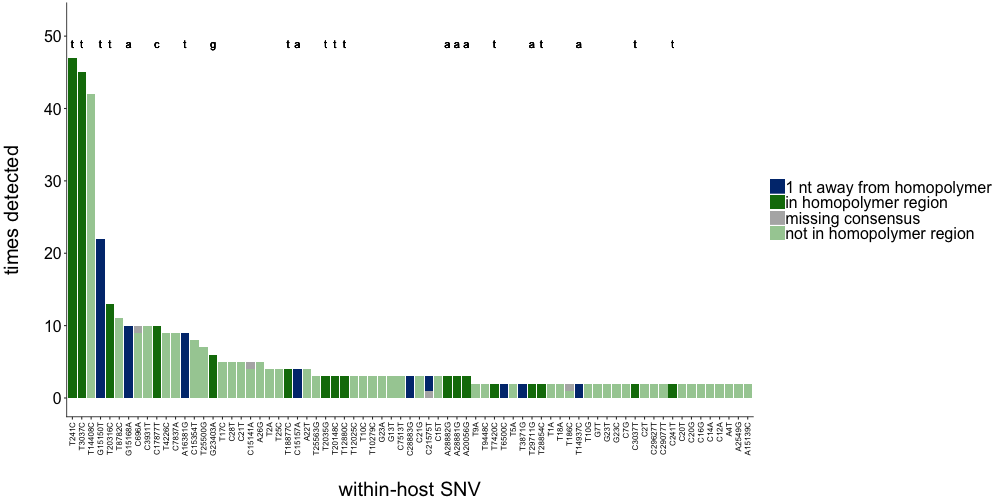

In [59]:
%%R -w 1000 -h 500 -u px -i times_detected_cutoff_to_plot,variant_percent,current_date,snvs_more_than_once,s_color,ns_color,stop_color,fs_color,fs_stop_color,order_of_snvs # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)

# subset to only SNVs present in more than 3 times
snvs_more_than_once <- snvs_more_than_once[(snvs_more_than_once$counts>=times_detected_cutoff_to_plot),]

output_filename = paste("counts-low-freq-snvs-3bp-homopolymer-",variant_percent,"percent-",current_date,".pdf", sep="")

snvs_more_than_once$SNV_f = factor(snvs_more_than_once$SNV, levels=c(order_of_snvs))
max_count = max(snvs_more_than_once$counts)

p2 <- ggplot(snvs_more_than_once, aes(x=SNV_f, y=classified_counts, fill=class))+
    geom_col()+
    geom_text(aes(x=SNV_f, y=max_count + 2, label=homopolymer_base))+
    scale_fill_manual(values=c(in_hp=ns_color, not_in_hp=s_color,adjacent=fs_color,no_consensus="grey70"), labels=c(in_hp="in homopolymer region",not_in_hp="not in homopolymer region",adjacent="1 nt away from homopolymer",no_consensus="missing consensus"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    scale_y_continuous(limits=c(0,max_count + 5), breaks=seq(0,max_count+5,10))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=20, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=20, vjust=0.5))+
    theme(axis.text.y=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(hjust=1, vjust=0.5, size=8, angle=90,colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    #theme(legend.position = c(0.9, 0.6))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nwithin-host SNV",y="times detected\n")
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave(output_filename, p2, width = 12, height = 4, path="../figures/")
p2

In [60]:
times_detected_cutoff_to_plot_indels = 2

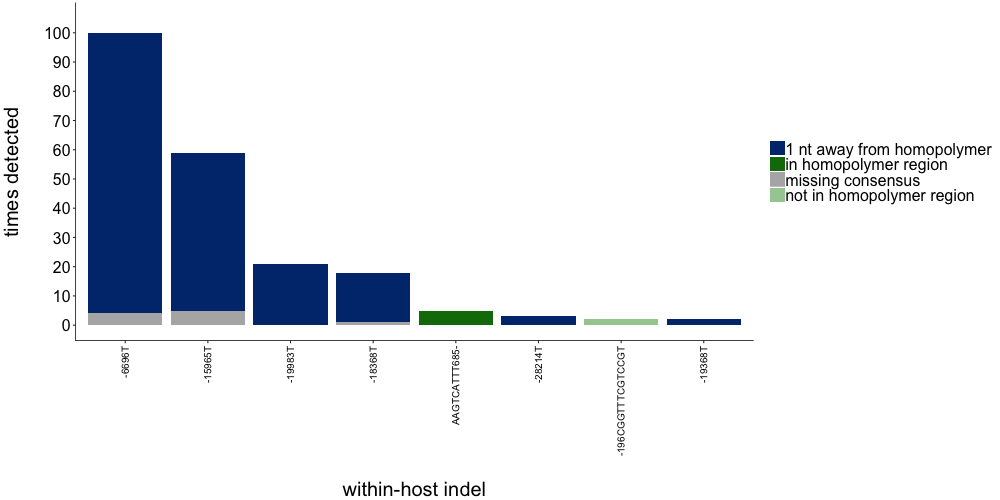

In [61]:
%%R -w 1000 -h 500 -u px -i times_detected_cutoff_to_plot_indels,variant_percent,current_date,indels_more_than_once,s_color,ns_color,stop_color,fs_color,fs_stop_color,order_of_indels # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)

indels_more_than_once <- indels_more_than_once[(indels_more_than_once$counts>=times_detected_cutoff_to_plot_indels),]

output_filename = paste("counts-low-freq-indels-3bp-homopolymer-",variant_percent,"percent-",current_date,".pdf", sep="")

indels_more_than_once$SNV_f = factor(indels_more_than_once$SNV, levels=c(order_of_indels))
max_count = max(indels_more_than_once$counts)

p3 <- ggplot(indels_more_than_once, aes(x=SNV_f, y=classified_counts, fill=class))+
    geom_col()+
    scale_color_manual(values=c(in_hp=ns_color, not_in_hp=s_color,adjacent=fs_color,no_annotation=fs_stop_color))+
    scale_fill_manual(values=c(in_hp=ns_color, not_in_hp=s_color,adjacent=fs_color,no_consensus="grey70"), labels=c(in_hp="in homopolymer region",not_in_hp="not in homopolymer region",adjacent="1 nt away from homopolymer",no_consensus="missing consensus"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    scale_y_continuous(limits=c(0,max_count+5), breaks=seq(0,max_count+5,10))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=20, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=20, vjust=0.5))+
    theme(axis.text.y=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(hjust=1, vjust=0.5, size=10, angle=90,colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    #theme(legend.position = c(0.9, 0.6))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nwithin-host indel",y="times detected\n")
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave(output_filename, p3, width = 12, height = 8, path="../figures/")
p3

## Check for 501YV1 an V2 sites: 

got the 501V1 sites here: https://virological.org/t/preliminary-genomic-characterisation-of-an-emergent-sars-cov-2-lineage-in-the-uk-defined-by-a-novel-set-of-spike-mutations/563

501v2 sites here: https://virological.org/t/tracking-the-international-spread-of-sars-cov-2-lineages-b-1-1-7-and-b-1-351-501y-v2/592

B.1.1.7:
orf1ab:T1001I; orf1ab:A1708D;
orf1ab:I2230T; del:11288:9; del:21765:6;
del:21991:3; S:N501Y; S:A570D; S:P681H;
S:T716I; S:S982A; S:D1118H; Orf8:Q27*;
Orf8:R52I; Orf8:Y73C; N:D3L; N:S235F

B.1.351/501Y-V2:
E:P71L; N:T205I; orf1a:K1655N; S:D80A;
S:D215G; S:K417N; S:E484K; S:N501Y;
S:E484K

In [62]:
def return_VOC_classification(SNV, b117_list, b1351_list):
    if SNV in b117_list: 
        classification = "B.1.1.7"
    elif SNV in b1351_list:
        classification = "B.1.351"
    else:
        classification = ""
    return(classification)

In [63]:
b117_nt_list = ["C3267T","C5388A","T6954C","11288-11296 deletion","21765-21770 deletion","21991-21993 deletion","A23063T","C23271A","C23604A","C23709T","T24506G","G24914C","C27972T","G28048T","A28111G","28280 GAT->CTA","C28977T"]
b117_aa_list = ["orf1ab_Thr1001Ile","orf1ab_Ala1708Asp","orf1ab_Ile2230Thr","orf1ab_SGF 3675-3677 deletion","S_HV 69-70 deletion","S_Y144 deletion","S_Asn501Tyr","S_Ala570Asp","S_Pro681His","S_Thr716Ile","S_Ser982Ala","S_Asp1118His","orf8_Gln27*","orf9_Arg52Ile","orf10_Tyr73Cys","N_Asp3Leu","N_Ser235Phe"]

b1351_aa_list = ["E_Pro71Leu","N_Thr205Ile","orf1a_Lys1655Asn","S_Asp80Ala","S_Apr215Gly","S_Lys417Asn","S_Asn501Tyr","S_Glu484Lys"]

In [64]:
s_aa['VOC'] = s_aa['SNV'].apply(return_VOC_classification, args=[b117_aa_list, b1351_aa_list])
print(set(s_aa['VOC'].tolist()))
s_aa[s_aa['VOC'] != '']

{'', 'B.1.351'}


,SNV,counts,VOC
185,N_Thr205Ile,1,B.1.351


## Test to see whether any of the recurrent variants are in this dataset

Using the list of putative masked variants [here](http://virological.org/t/issues-with-sars-cov-2-sequencing-data/473), see if any of these sites are present in the within-host data. 

**They recommend this:**

*Secondly, we propose masking sites that appear to be highly homoplasic and have no phylogenetic signal and/or low prevalence – these can be recurrent artefacts, or otherwise hypermutable low-fitness sites that might similarly cause phylogenetic noise. A current list of these is:
187, 1059, 2094, 3037, 3130, 6990, 8022, 10323, 10741, 11074, 13408, 14786, 19684, 20148, 21137, 24034, 24378, 25563, 26144, 26461, 26681, 28077, 28826, 28854, 29700.
We provide technical details of how these sites were identified below, however please note that all lists of sites outlined here are a work in progress, and might be affected by many choices made in the preliminary phylogenetic steps.*

*In addition, we suggest masking any homoplasic positions that are exclusive to a single sequencing lab or geographic location, regardless of phylogenetic signal. Here the phylogenetic signal might be caused by a common source of error (among other things). Our current list is:
4050, 13402.*

*We also recommend masking of positions that, despite having strong phylogenetic signal, are also strongly homoplasic. These may be caused by hypermutability at certain positions, although it is hard to rule out any possibility for now. Our current list is:
11083, 15324, 21575*


This paragraph of that blog is particularly useful. They split up all of the consensus sequences into those generated by nanopore, Illumina, or by KU Leuven. This is what they found: 

*We re-analysed these 3 datasets individually using TreeTime. The most predominant homoplasies were common across technology and country, including G11083T, C16887T, C21575T and C15324T. Others were exclusive to Illumina (most remarkably C11074T, C6990T, C29353T, and C29774T) while others were exclusive to nanopore. Surprisingly dataset C contained more homoplasies than B (Figure 8), of which many are mutations only found in C (e.g. T13402G, A4050C, T13408C, T8022G, C3130T, T28785G). Each of these homoplasies could in principle also be caused by issues with phylogenetic inference, which itself can be affected by homoplasic substitutions.*

They also note that some of these recurrent mutations, like at 11083 and 11074 extend long homopolymer T regions. 11074 is also Illumina specific in their analysis. They note that 11083 reverts multiple times on the tree as well.

In [65]:
def return_de_Maio_classification(SNV):
    masked_sites = [187, 1059, 2094, 3037, 3130, 6990, 8022, 10323, 10741, 11074, 13408, 14786, 19684, 20148, 21137, 24034, 24378, 25563, 26144, 26461, 26681, 28077, 28826, 28854, 29700]
    lab_specific = [4050, 13402]
    homoplasic = [11083, 15324, 21575]
    illumina_specific = ["C11074T", "C6990T", "C29353T", "C29774T"]
    
    # remove all nondigits
    site = int(''.join(filter(str.isdigit, SNV)))
    if SNV in illumina_specific: 
        annotation = "illumina_specific"
    elif site in masked_sites: 
        annotation = "masked"
    elif site in lab_specific: 
        annotation = "lab_specific"
    elif site in homoplasic:
        annotation = "homoplasic"
    else:
        annotation = "none"
    
    return(annotation)

In [66]:
snvs_more_than_once['de_Maio_class'] = snvs_more_than_once['SNV'].apply(return_de_Maio_classification)
indels_more_than_once['de_Maio_class'] = indels_more_than_once['SNV'].apply(return_de_Maio_classification)

snvs_more_than_once.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,SNV,counts,classified_counts,class,homopolymer_base,de_Maio_class
0,T241C,47,47,in_hp,t,none
0,T241C,47,0,not_in_hp,t,none
0,T241C,47,0,adjacent,t,none
0,T241C,47,0,no_consensus,t,none
0,T3037C,45,45,in_hp,t,masked


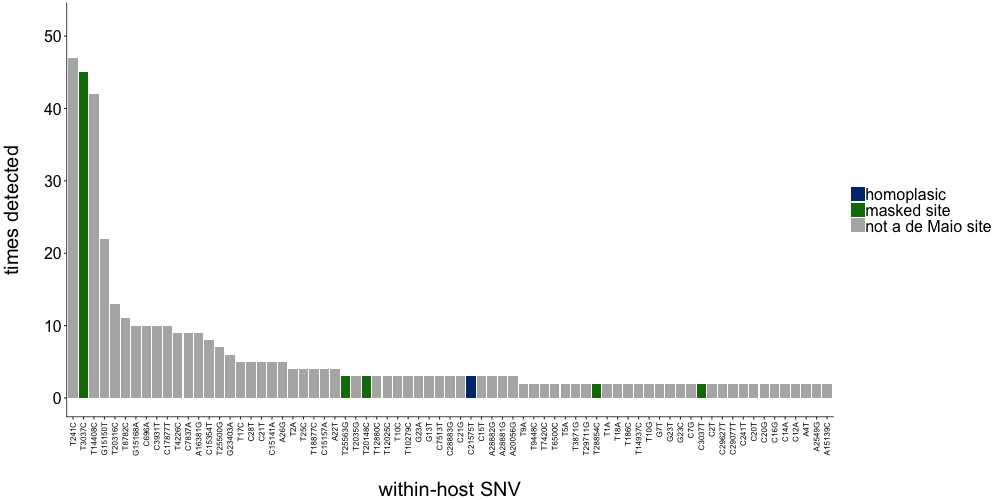

In [67]:
%%R -w 1000 -h 500 -u px -i variant_percent,current_date,snvs_more_than_once,s_color,ns_color,stop_color,fs_color,fs_stop_color,order_of_snvs # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)

output_filename = paste("counts-snvs-de-maio-",variant_percent,"percent-",current_date,".pdf", sep="")

snvs_more_than_once$SNV_f = factor(snvs_more_than_once$SNV, levels=c(order_of_snvs))
max_count = max(snvs_more_than_once$counts)

p2 <- ggplot(snvs_more_than_once, aes(x=SNV_f, y=classified_counts, fill=de_Maio_class))+
    geom_col()+
    scale_fill_manual(values=c(masked=ns_color, lab_specific=s_color, illumina_specific=s_color,homoplasic=fs_color,none="grey70"), labels=c(masked="masked site",lab_specific="lab-specific variant",illumina_specific = "illumina specific", homoplasic="homoplasic",none="not a de Maio site"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    scale_y_continuous(limits=c(0,max_count+5), breaks=seq(0,max_count+5,10))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=20, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=20, vjust=0.5))+
    theme(axis.text.y=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(hjust=1, vjust=0.5, size=8, angle=90,colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    #theme(legend.position = c(0.9, 0.6))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nwithin-host SNV",y="times detected\n")
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave(output_filename, p2, width = 12, height = 4, path="../figures/")
p2

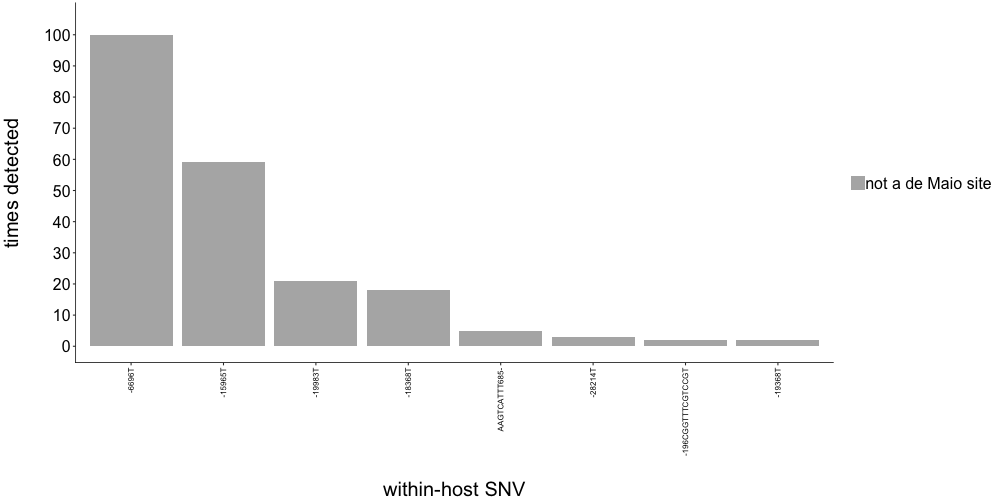

In [68]:
%%R -w 1000 -h 500 -u px -i variant_percent,current_date,indels_more_than_once,s_color,ns_color,stop_color,fs_color,fs_stop_color,order_of_indels # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)

output_filename = paste("counts-indels-de-maio-",variant_percent,"percent-",current_date,".pdf", sep="")

indels_more_than_once$SNV_f = factor(indels_more_than_once$SNV, levels=c(order_of_indels))
max_count = max(indels_more_than_once$counts)

p2 <- ggplot(indels_more_than_once, aes(x=SNV_f, y=classified_counts, fill=de_Maio_class))+
    geom_col()+
    scale_fill_manual(values=c(masked=ns_color, lab_specific=s_color, illumina_specific=s_color,homoplasic=fs_color,none="grey70"), labels=c(masked="masked site",lab_specific="lab-specific variant",illumina_specific = "illumina specific", homoplasic="homoplasic",none="not a de Maio site"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    scale_y_continuous(limits=c(0,max_count+5), breaks=seq(0,max_count+5,10))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=20, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=20, vjust=0.5))+
    theme(axis.text.y=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(hjust=1, vjust=0.5, size=8, angle=90,colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    #theme(legend.position = c(0.9, 0.6))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nwithin-host SNV",y="times detected\n")
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave(output_filename, p2, width = 9, height = 8, path="../figures/")
p2

So...a lot of the shared variants do appear to be at these sites that they masked. There is a long thread in our slack about this, and Trevor does not seem to think that these are issues. I'm not really sure what to think to be honest. (link to slack: https://bedfordlab.slack.com/archives/CSKMU6YUC/p1589287709383400). 

After reading a bit more about this in detail, it seems like 11083 might just be a real, hypermutable spot. I think that given how well-characterized this within-host data is, that would be a nice addition to the literature (because they have duplicate sequencing and will have sequenced with 2 different methods). I find the Illumina specific mutations a little weird. I guess I do also wonder what is causing these specific mutations. Illumina sequencing has exceptionally low error rates and I would be shocked if these were induced by the sequencer itself. I would find it much more likely that this has to do with RT-PCR primers and cycling conditions. But not sure. 

## Compare to Lythgoe sites

They very conveniently have their SNVs available in their github repo, [here](https://github.com/katrinalythgoe/COVIDdiversity) -> however, it looks like that file has now been deleted. I think that they updated their results, so maybe they will put up a new file. 

In [69]:
def read_in_lythgoe_sites(lythgoe_input_file):
    lythgoe_dict = {}
    
    with open(lythgoe_input_file, "r") as infile: 
        for line in infile: 
            if "reference_position" not in line: 
                site = int(line.split(",")[0])
                counts_within_host = line.split(",")[6]
                lythgoe_dict[site] = {"within-host-counts":counts_within_host}
    
    return(lythgoe_dict)

In [70]:
def read_in_scan_sites(scan_input_file):
    scan_sites = {}
    
    with open(scan_input_file, "r") as infile: 
        for line in infile:
            if "snv" not in line:
                site = int(line.split("\t")[0][:-1])
                counts = line.split("\t")[1]
            
                scan_sites[site] = counts
            
    return(scan_sites)

In [71]:
def return_lythgoe_classification(SNV, lythgoe_dict):

    # remove all nondigits
    site = int(''.join(filter(str.isdigit, SNV)))
    if site in lythgoe_dict: 
        annotation = "lythgoe_site"
    else:
        annotation = "none"
    
    return(annotation)

In [72]:
def return_scan_classification(SNV, scan_dict):

    # remove all nondigits
    site = int(''.join(filter(str.isdigit, SNV)))
    if site in scan_dict: 
        annotation = "scan_site"
    else:
        annotation = "none"
    
    return(annotation)

In [73]:
def return_lythgoe_counts(SNV, lythgoe_dict):

    # remove all nondigits
    site = int(''.join(filter(str.isdigit, SNV)))
    if site in lythgoe_dict: 
        counts = int(lythgoe_dict[site]['within-host-counts'])
    else:
        counts = 0
    
    return(counts)

In [74]:
def return_label(row):
    counts = int(row['counts'])
    lythgoe_counts = int(row['lythgoe_counts'])
    snv = row['SNV']
    
    if counts >= 20 or lythgoe_counts >= 20:
        label = snv
    else:
        label = ""
        
    return(label)

In [75]:
lythgoe_input_file = "/Users/lmoncla/src/ncov-WI-within-host/data/lythgoe-shared-sites-2020-12-14.tsv"
lythgoe_dict = read_in_lythgoe_sites(lythgoe_input_file)

scan_input_file = "/Users/lmoncla/src/ncov-WI-within-host/data/seattle-data/SNV_sites_SCAN.tsv"
scan_dict = read_in_scan_sites(scan_input_file)

In [76]:
snvs_more_than_once['lythgoe_class'] = snvs_more_than_once['SNV'].apply(return_lythgoe_classification, args=[lythgoe_dict])
snvs_more_than_once['scan_class'] = snvs_more_than_once['SNV'].apply(return_scan_classification, args=[scan_dict])
snvs_more_than_once['lythgoe_counts'] = snvs_more_than_once['SNV'].apply(return_lythgoe_counts, args=[lythgoe_dict])
snvs_more_than_once['label'] = snvs_more_than_once.apply(return_label, axis=1)

indels_more_than_once['lythgoe_class'] = indels_more_than_once['SNV'].apply(return_lythgoe_classification, args=[lythgoe_dict])
indels_more_than_once['lythgoe_counts'] = indels_more_than_once['SNV'].apply(return_lythgoe_counts, args=[lythgoe_dict])
indels_more_than_once['label'] = indels_more_than_once.apply(return_label, axis=1)

snvs_more_than_once.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

,SNV,counts,classified_counts,class,homopolymer_base,de_Maio_class,lythgoe_class,scan_class,lythgoe_counts,label
0,T241C,47,47,in_hp,t,none,lythgoe_site,none,0,T241C
0,T241C,47,0,not_in_hp,t,none,lythgoe_site,none,0,T241C
0,T241C,47,0,adjacent,t,none,lythgoe_site,none,0,T241C
0,T241C,47,0,no_consensus,t,none,lythgoe_site,none,0,T241C
0,T3037C,45,45,in_hp,t,masked,lythgoe_site,none,0,T3037C


In [80]:
times_detected_cutoff_to_plot = 2

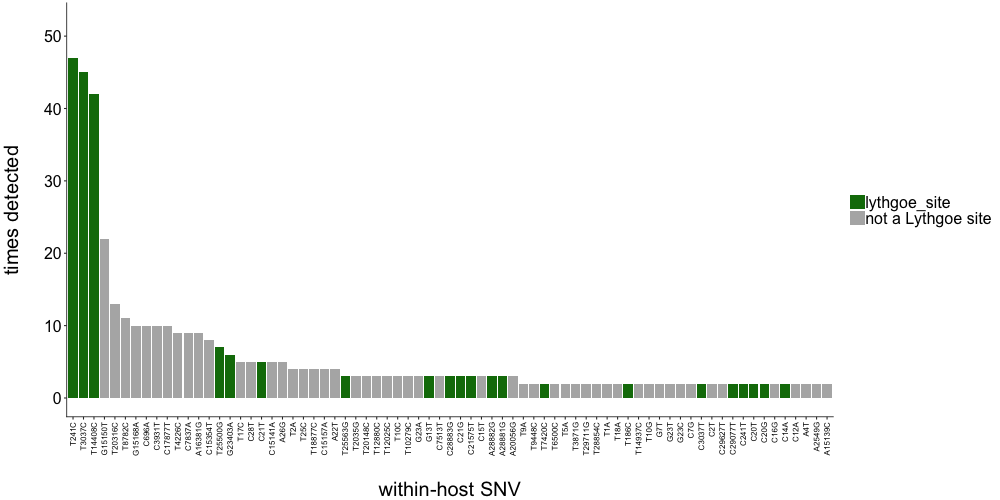

In [81]:
%%R -w 1000 -h 500 -u px -i times_detected_cutoff_to_plot,variant_percent,current_date,snvs_more_than_once,s_color,ns_color,stop_color,fs_color,fs_stop_color,order_of_snvs # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)

snvs_more_than_once <- snvs_more_than_once[(snvs_more_than_once$counts>=times_detected_cutoff_to_plot),]

output_filename = paste("counts-snvs-lythgoe-",variant_percent,"percent-",current_date,".pdf", sep="")

snvs_more_than_once$SNV_f = factor(snvs_more_than_once$SNV, levels=c(order_of_snvs))
max_count = max(snvs_more_than_once$counts)

p2 <- ggplot(snvs_more_than_once, aes(x=SNV_f, y=classified_counts, fill=lythgoe_class))+
    geom_col()+
    scale_fill_manual(values=c(lythgoe_site=ns_color, none="grey70"), labels=c(lythgoe_color="Lythgoe site",none="not a Lythgoe site"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    scale_y_continuous(limits=c(0,max_count+5), breaks=seq(0,max_count+5,10))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=20, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=20, vjust=0.5))+
    theme(axis.text.y=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(hjust=1, vjust=0.5, size=8, angle=90,colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    #theme(legend.position = c(0.9, 0.6))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nwithin-host SNV",y="times detected\n")
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave(output_filename, p2, width = 12, height = 4, path="../figures/")
p2

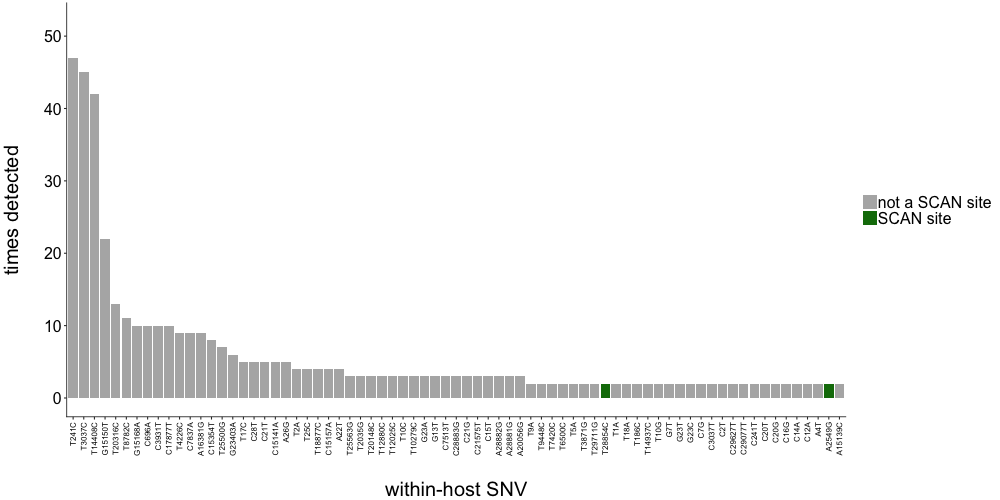

In [82]:
%%R -w 1000 -h 500 -u px -i times_detected_cutoff_to_plot,variant_percent,current_date,snvs_more_than_once,s_color,ns_color,stop_color,fs_color,fs_stop_color,order_of_snvs # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)

snvs_more_than_once <- snvs_more_than_once[(snvs_more_than_once$counts>=times_detected_cutoff_to_plot),]

output_filename = paste("counts-snvs-SCAN-",variant_percent,"percent-",current_date,".pdf", sep="")

snvs_more_than_once$SNV_f = factor(snvs_more_than_once$SNV, levels=c(order_of_snvs))
max_count = max(snvs_more_than_once$counts)

p2 <- ggplot(snvs_more_than_once, aes(x=SNV_f, y=classified_counts, fill=scan_class))+
    geom_col()+
    scale_fill_manual(values=c(scan_site=ns_color, none="grey70"), labels=c(scan_site="SCAN site",none="not a SCAN site"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    scale_y_continuous(limits=c(0,max_count+5), breaks=seq(0,max_count+5,10))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=20, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=20, vjust=0.5))+
    theme(axis.text.y=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(hjust=1, vjust=0.5, size=8, angle=90,colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    #theme(legend.position = c(0.9, 0.6))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nwithin-host SNV",y="times detected\n")
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave(output_filename, p2, width = 12, height = 4, path="../figures/")
p2

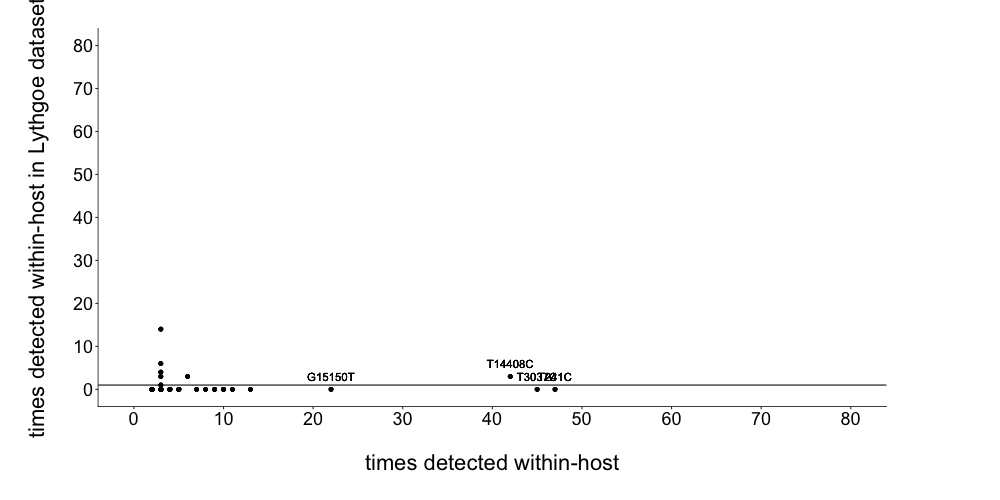

In [83]:
%%R -w 1000 -h 500 -u px -i variant_percent,current_date,snvs_more_than_once,s_color,ns_color,stop_color,fs_color,fs_stop_color,order_of_snvs # this sets the size of the plot...otherwise, it will go off the page\n",

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("SNVs-counts-vs-lythgoe-",variant_percent,"percent-",current_date,".pdf", sep="")

p <- ggplot(data=snvs_more_than_once, aes(x=counts, y=lythgoe_counts)) + 
    geom_point()+
    geom_hline(yintercept=1)+
    labs(x="\ntimes detected within-host",y="times detected within-host in Lythgoe dataset\n")+
    geom_text(aes(x=counts,y=lythgoe_counts + 3,label=label), size=4)+
    scale_y_continuous(breaks=seq(0,80,10), limits=c(0,80))+
    scale_x_continuous(breaks=seq(0,80,10), limits=c(0,80))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=22, vjust=5))+
    theme(axis.text.y=element_text(size=18, colour="black"))+
    theme(axis.text.x=element_text(size=18, colour="black"))+
    theme(legend.text=element_text(size=18))+
    theme(legend.title=element_text(size=22))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.position = c(1.0, 0.75))+
    guides(fill=guide_legend(title="where SNV arose"))

ggsave(output_filename, width = 9, height = 7, device = "pdf", path = "../figures/", dpi = 300)
p

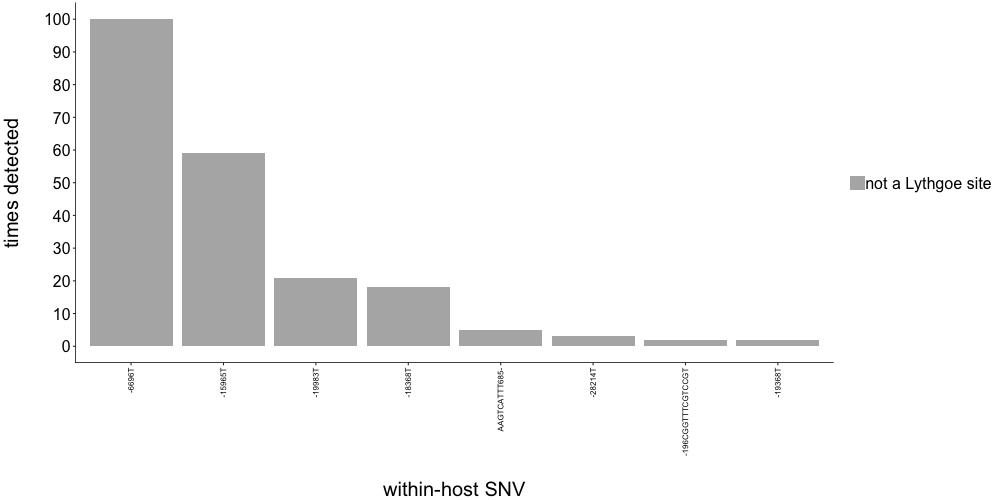

In [84]:
%%R -w 1000 -h 500 -u px -i variant_percent,current_date,indels_more_than_once,s_color,ns_color,stop_color,fs_color,fs_stop_color,order_of_indels # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)

output_filename = paste("counts-indels-lythgoe-",variant_percent,"percent-",current_date,".pdf", sep="")

indels_more_than_once$SNV_f = factor(indels_more_than_once$SNV, levels=c(order_of_indels))

p2 <- ggplot(indels_more_than_once, aes(x=SNV_f, y=classified_counts, fill=lythgoe_class))+
    geom_col()+
    scale_fill_manual(values=c(lythgoe_site=ns_color, none="grey70"), labels=c(lythgoe_color="Lythgoe site",none="not a Lythgoe site"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    scale_y_continuous(limits=c(0,100), breaks=seq(0,100,10))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=20, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=20, vjust=0.5))+
    theme(axis.text.y=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(hjust=1, vjust=0.5, size=8, angle=90,colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    #theme(legend.position = c(0.9, 0.6))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nwithin-host SNV",y="times detected\n")
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave(output_filename, p2, width = 9, height = 8, path="../figures/")
p2

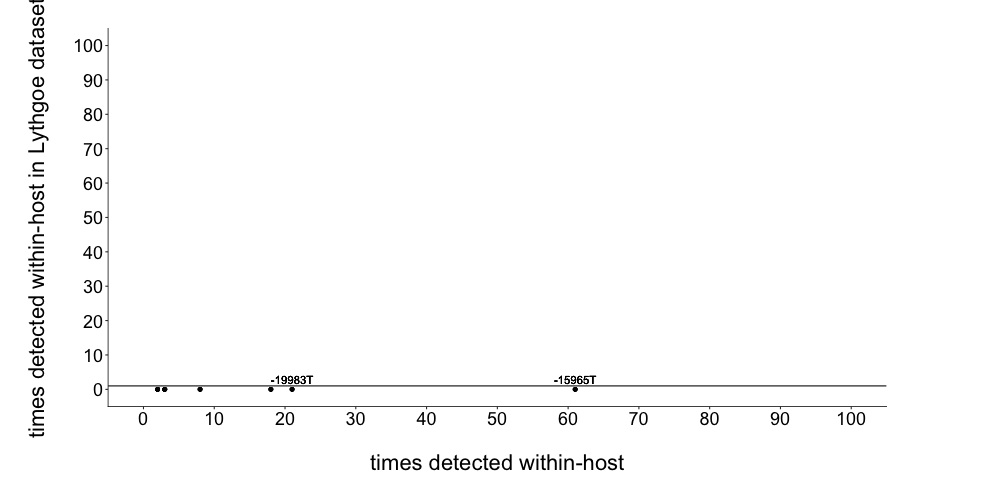

In [170]:
%%R -w 1000 -h 500 -u px -i variant_percent,current_date,indels_more_than_once,s_color,ns_color,stop_color,fs_color,fs_stop_color,order_of_snvs # this sets the size of the plot...otherwise, it will go off the page\n",

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("indels-counts-vs-lythgoe-",variant_percent,"percent-",current_date,".pdf", sep="")

p <- ggplot(data=indels_more_than_once, aes(x=counts, y=lythgoe_counts)) + 
    geom_point()+
    geom_hline(yintercept=1)+
    labs(x="\ntimes detected within-host",y="times detected within-host in Lythgoe dataset\n")+
    geom_text(aes(x=counts,y=lythgoe_counts + 3,label=label), size=4)+
    scale_y_continuous(breaks=seq(0,100,10), limits=c(0,100))+
    scale_x_continuous(breaks=seq(0,100,10), limits=c(0,100))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=22, vjust=5))+
    theme(axis.text.y=element_text(size=18, colour="black"))+
    theme(axis.text.x=element_text(size=18, colour="black"))+
    theme(legend.text=element_text(size=18))+
    theme(legend.title=element_text(size=22))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.position = c(1.0, 0.75))+
    guides(fill=guide_legend(title="where SNV arose"))

ggsave(output_filename, width = 9, height = 7, device = "pdf", path = "../figures/", dpi = 300)
p